# 모델 데모

**제안 기법 : 키워드를 기준으로 댓글 선별 + 클러스터링**

- **0~1 : 사전 준비**
- **2~3 : 데이터 전처리**
- **4~5 : 키워드 기반 댓글 선별**
- **6 : 클러스터링**
- **7 : 모델 평가 & 비교 & 하이퍼 파라미터 튜닝**
- **8 :  요약**
- **9 : 시각화 (PPT용)**

## 0. 라이브러리 설치

In [1]:
#라이브러리 설치
!pip install sentence-transformers scikit-learn pandas openpyxl hdbscan scikit-learn-extra openai umap-learn keybert
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab_light_220429.sh
%cd ..

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.2 MB/s eta 0:00:00
Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 138 (delta 26), reused 22 (delta 8), pack-reused 91 (from 1)
Receiving objects: 100% (138/138), 1.72 MiB | 6.78 MiB/s, done.
Resolving deltas: 100% (65/65), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.8/493.8 kB 35.0 MB/s eta 0:00:00
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-k

## 1. 라이브러리 임포트 & 전처리용 함수 선언

In [26]:
#라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from umap import UMAP
from keybert import KeyBERT
from collections import defaultdict
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# 좋아요 수 숫자 자료형으로 변환 (ex 1.4K -> 1400)
def convert_likes_to_number(likes):
    if isinstance(likes, str):
        likes = likes.strip().upper()  # 대소문자 무시
        if 'K' in likes:  # 1K = 1,000
            return float(likes.replace('K', '')) * 1_000
        elif 'M' in likes:  # 1M = 1,000,000
            return float(likes.replace('M', '')) * 1_000_000
        else:
            return float(likes)  # 숫자만 있는 경우
    return likes  # 이미 숫자인 경우 그대로 반환

## 2. 엑셀 파일 (하나의 영상에서 크롤링한 댓글) 읽기 & 전처리

총 5개의 영상을 사용하여 확인해볼 예정입니다.

- (두 번째로) 치명적인 바이러스
- (추석연휴특집영상) X는 Y인가 + 머스크형 씨리즈
- (추석연휴특집영상2) 러시아-우크라이나 정주행
- 공룡 멸종의 날 - 모든 순간들
- [SUB] 오늘은 알콜 프리🎵 근데 향기✨에 취해~  [차린건 쥐뿔도 없지만] EP.04 #이영지 #김향기 (ENGJPNSPA)

In [2]:
# 크롤링한 엑셀 파일 읽기
df = pd.read_excel('Youtube Comments.xlsx')

# comment 열 문자열 자료형 변환 및 NaN 삭제
df['comment'] = df['comment'].astype(str)
df = df[df['comment'].notna()]

# num_likes 열 숫자 자료형으로 변환
df['num_likes'] = df['num_likes'].apply(convert_likes_to_number)

# NaN 값 -> 0 으로 변환
df['num_likes'] = pd.to_numeric(df['num_likes'], errors='coerce').fillna(0)

df

,Unnamed: 0,author,comment,num_likes
0,0,@kurzgesagt_kr,"Kurzgesagt를 직접 후원하고 싶다면, 저희 스토어에서 상품을 구매하거나 Pa...",103
1,1,@Sul_hyun,😢😢공롱들,0
2,2,@rlgh24,저걸 겪고도 25%의 생물종들이 살아남았다는게 놀랍다.,0
3,3,@Motion_Crab,"한국어 캡션중에 <a href=""https://www.youtube.com/watc...",0
4,4,@hanihaya6372,좋은 영화 한 편 본 기분,1
...,...,...,...,...
229,229,@lunarbunny450,2,1
230,230,@큐브-m8s,와!! 내 베스트 왔다!!,1
231,231,@hyundo1321,와 🎉🎉🎉,0
232,232,@근우1468,와 공룡!,0


## 3.불용어 삭제 & 명사구 추출
- 준모님이 준비해주신 코드로 변경 예정입니다.
- 키워드를 뽑기 위해 댓글마다 명사구들을 추출하였습니다.

In [3]:
from konlpy.tag import Mecab

comments = df['comment'].tolist()

# Mecab 사용
mecab = Mecab()

# 불용어 목록
stopwords = ['은', '는', '이', '가', '을', '를', '에', '의', '로', '와', '과', '하다', '있다', '없다']

# 불용어 제거 및 명사구 추출을 위한 함수
def extract_nouns(comment, tokenizer, stopwords):
    # 명사구 추출
    nouns = tokenizer.nouns(comment)
    # 불용어 제거
    filtered_nouns = [noun for noun in nouns if noun not in stopwords]
    return " ".join(filtered_nouns)

# 모든 댓글마다 함수 적용
nouns_per_comment = [extract_nouns(comment, mecab, stopwords) for comment in comments]

# 결과 출력
print("Original Comments:", comments)
print("Nouns for Comments:", nouns_per_comment)

Original Comments: ['Kurzgesagt를 직접 후원하고 싶다면, 저희 스토어에서 상품을 구매하거나 Patron이 되어주세요.<br>Shop: <a href="https://kgs.link/shop">https://kgs.link/shop</a><br>Patreon: <a href="https://kgs.link/patreon">https://kgs.link/patreon</a><br>정말 감사합니다!', '😢😢공롱들', '저걸 겪고도 25%의 생물종들이 살아남았다는게 놀랍다.', '한국어 캡션중에 <a href="https://www.youtube.com/watch?v=bZaIPm1oGkQ&amp;t=273">4:33</a> 킬로미터에 달아는 오타 있습니당', '좋은 영화 한 편 본 기분', '너도 멸종되지 않게 조심해', '생명에 대한 큰 허상중 하나는 연속성이다... 시작부터 개띵언 박고 들어오시네 ㄷㄷ', '공룡은 수억년간을 생존해도 고차원적인 진화를 이루지 못하였으니<br>외계의 연구가들은<br>거대 파충류에서 작은 포유류로<br>연구 대상을 바꾸기로 결정했다.', '제발 다시 떨어졌으면.. 매일 기도합니다', '티라노 귀신', '<a href="https://www.youtube.com/watch?v=bZaIPm1oGkQ&amp;t=360">6:00</a> 이.... 귀엽다가도 한순간에 ㄷㄷㄷ <br><br>이게 독일식 유머인가', '와 내 인생 영화', '왜 영상 내용에 대해 말하는 사람은 없고 채널 빠는 놈들밖에 없지.....', '내용이 완벽한데 뭐 더 말할게 있냐?', '욱일기 연상시키는 모양 종종 나와서 거슬림', '공상을 더하자면 수 많은 정보를 전달하는 방법이 꿈이라는 매개체일  수 있을지도요, 꿈이라는 공간을 초월하는 정보전달 체계의 의식공간이라던가요.', '극도로 발달한 외계 문명이 생명의 씨앗을 뿌렸고 관찰을 하고 있었다, 관찰의 이유는 유희, 종족의 번영, 다른  문명의 발달 지식, 연구 등 다양할 수 있고 고도화

## 4.댓글마다 키워드 추출

In [4]:
# KeyBERT 사용
model = SentenceTransformer("jhgan/ko-sroberta-multitask")
keybert_model = KeyBERT(model)

# 댓글 별 키워드 추출
keywords_per_comment = [
    keybert_model.extract_keywords(comment, top_n=2, keyphrase_ngram_range=(1,1))  # Extract 1-2 word phrases
    for comment in nouns_per_comment
]

# 결과 출력
for comment, keywords in zip(nouns_per_comment, keywords_per_comment):
    print(f"Comment: {comment}")
    print(f"Keywords: {keywords}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Comment: 후원 저희 스토어 상품 구매 감사
Keywords: [('감사', 0.6039), ('스토어', 0.5854)]
Comment: 공 롱
Keywords: []
Comment: 저걸 물종 게
Keywords: [('물종', 0.883), ('저걸', 0.617)]
Comment: 한국어 캡션 중 킬로미터 오타
Keywords: [('한국어', 0.6854), ('오타', 0.5938)]
Comment: 영화 편 기분
Keywords: [('영화', 0.8115), ('기분', 0.5274)]
Comment: 너 멸종 조심
Keywords: [('멸종', 0.7142), ('조심', 0.6293)]
Comment: 생명 허상 중 하나 연속 시작 개 박고 ㄷ ㄷ
Keywords: [('생명', 0.5154), ('허상', 0.4567)]
Comment: 공룡 수억 년 간 생존 고차원 진화 외계 연구가 거대 파충류 포유 연구 대상 결정
Keywords: [('공룡', 0.549), ('파충류', 0.4344)]
Comment: 기도
Keywords: [('기도', 1.0)]
Comment: 티라노 귀신
Keywords: [('티라노', 0.8058), ('귀신', 0.6495)]
Comment: 순간 ㄷ ㄷ ㄷ 이게 독일 유머
Keywords: [('독일', 0.6881), ('순간', 0.4176)]
Comment: 내 인생 영화
Keywords: [('영화', 0.7469), ('인생', 0.4768)]
Comment: 영상 내용 말 사람 채널 놈
Keywords: [('영상', 0.6089), ('채널', 0.6011)]
Comment: 내용 완벽 말 게
Keywords: [('내용', 0.6126), ('완벽', 0.4869)]
Comment: 욱일기 연상 모양
Keywords: [('욱일기', 0.9081), ('모양', 0.5321)]
Comment: 공상 수 정보 전달 방법 꿈 매개체 수 꿈 공간 초월 정보 전달 체계 의식 공간
Keywo

In [5]:
# 결과 형식 변환 ([('트럼프',0.1234),('해리스',0.5678)] => ['트럼프','해리스'])
keywords_per_comment = [
    [kw[0] for kw in keywords]
    for keywords in keywords_per_comment
]

In [6]:
# 키워드 별로 댓글 모으기
from collections import defaultdict

keyword_to_comments = defaultdict(list)

# 키워드 별로 댓글 추가 (댓글의 index를 추가)
for comment_idx, keywords in enumerate(keywords_per_comment):
    for keyword in keywords:
        keyword_to_comments[keyword].append(comment_idx)

# 키워드 당 댓글 수를 기준으로 정렬
sorted_keywords = sorted(
    keyword_to_comments.items(),
    key=lambda x: len(x[1]),
    reverse=True
)

# 결과 출력
print("Keyword-based Clusters (Sorted by Number of Comments):")
for keyword, comment_indices in sorted_keywords:
    print(f"Keyword: {keyword} (Count: {len(comment_indices)})")
    print(f"Comments: {[comments[idx] for idx in comment_indices]}")

Keyword-based Clusters (Sorted by Number of Comments):
Keyword: 공룡 (Count: 28)
Comments: ['공룡은 수억년간을 생존해도 고차원적인 진화를 이루지 못하였으니<br>외계의 연구가들은<br>거대 파충류에서 작은 포유류로<br>연구 대상을 바꾸기로 결정했다.', '지구에서 공룡의 능력으론 운석충돌에서 살아남지 못했고, 지적생명체의 탄생으로 그 위기를 막게 진화한 것..', '공룡보다 인간이 더 빨리 멸종할듯!!!', '옛날에 공룡들은 고질라 느낌이였는데<br>이제는 이빨 있는 새 같이 그려지는게 신기합니다<br>깃털이 있을거라고는 어릴때 생각도 못함', '🙏😔공룡 R.I.P \U0001fae1', '공룡이 멸종한 이유는 거대운석<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>의 충돌로부터 지구를 지켯기 때문에!!<br><br>포유류:공룡들의 생명이 꺼져가고있어!ㅠ', '공룡 덕후로서 너무 맘에들고 내용이 쏙쏙 박히는 디자인이당', '공룡 불쌍해', '공룡이 태어나서 멸종되는 시간의 겨우 1000분의 1밖에 안 산 인간이 벌서 공룡을 멸종 시킨 그 소행성을 파괴하는 실험까지 하는데 성공했습니다. 공룡이 살아간 시간의 100분의 1만 큼의 인간이 살아가고 있을 때 인간은 소행성 따위는 전혀 신경도 안 쓰는 기술을 이룬 시대에 살고 있을 것입니다.', '공룡들이 갑자기 불쌍하다 ㅠㅠ 얼마나 고통스러웠을까 살아남은 몇몇은...', '<a href="https://www.youtube.com/watch?v=bZaIPm1oGkQ&amp;t=511">8:31</a>  조류는 공룡의 직계후손이 아닌 공룡이 맞아요 유일하게 살아남은 수각류 공룡이죠', '공룡 :ㅅㅂ', '내용 중 9분에 공룡의 역사 &quot;1억 650만년 =&gt; 1억 6500만년(165million years)&quot;으로 수정이 필요합니

## 5. 키워드 합치기 (키워드 그룹 만들기) & 중복 제거

- 키워드 합치는 기준 : 서로 동일한 댓글 수가 (Threshold)개 이상

- 중복 제거 알고리즘 : 같은 댓글이 여러 개의 그룹에 중복되어 속해있는 경우, 가장 많은 댓글을 가진 그룹에 속한 댓글만 남겨두고 나머지는 제거 (차후 개선가능)

- 댓글 수 기준으로 상위 5개 그룹 선택

In [7]:
# 키워드 합치기 & 중복 제거
indices = {keyword: set(index_list) for keyword, index_list in sorted_keywords}

# 댓글 수 Threshold
overlap_threshold = 30

# 동일한 댓글을 (Threshold)개 이상으로 포함하는 키워드는 서로 합치기
groups = defaultdict(set)  # 각 키워드 그룹에 속할 댓글을 저장할 딕셔너리
visited = set()  # 이미 합쳐진 키워드 트래킹

for keyword1, indices1 in indices.items():
    # 키워드가 합쳐지지 않았다면 새로 그룹을 생성
    if keyword1 in visited:
        continue
    groups[keyword1].update(indices1)

    # 겹치는 댓글이 (Threshold)개 이상인지 확인하고 맞다면 키워드 합치기
    for keyword2, indices2 in indices.items():
        if keyword1 != keyword2:
            overlap_count = len(indices1 & indices2)
            if overlap_count >= overlap_threshold:
                groups[keyword1].update(indices2)
                visited.add(keyword2)


# 그룹 형식 변환 ({'트럼프':{1,2,3},'바이든':{4,5,6}} => {'트럼프':(1,2,3),'바이든':(4,5,6)})
final_groups = {}
for keyword, group_indices in groups.items():
    group_indices = sorted(group_indices)  # Sort indices for consistency
    if tuple(group_indices) not in final_groups.values():
        final_groups[keyword] = tuple(group_indices)

# 그룹 간 중복되는 댓글 제거
assigned_indices = set()  # 이미 최종 그룹에 할당된 댓글 트래킹
cleaned_groups = {} # 최종 그룹

# 그룹 별 댓글 수를 기준으로 정렬
sorted_groups = sorted(final_groups.items(), key=lambda x: len(x[1]), reverse=True)

# 같은 댓글이 여러 개의 그룹에 중복되어 속해있는 경우, 가장 많은 댓글을 가진 그룹에 속한 댓글만 남겨두고 나머지는 제거
for keyword, group_indices in sorted_groups:
    unique_indices = tuple(idx for idx in group_indices if idx not in assigned_indices)
    if unique_indices:  # Only keep groups with remaining indices
        cleaned_groups[keyword] = unique_indices
        assigned_indices.update(unique_indices)

# 전체 그룹 중에서 댓글 수 기준으로 Top 5에 해당하는 그룹을 추출 (스팸 댓글들도 삭제되는 효과)
top_cleaned_groups = sorted(cleaned_groups.items(), key=lambda x: len(x[1]), reverse=True)[:5]

# 결과 출력
print("Top 5 Groups (Sorted by Number of Indices):")
for keyword, group_indices in top_cleaned_groups:
    print(f"Keyword Group Representative: {keyword}, Indices: {group_indices}")

Top 5 Groups (Sorted by Number of Indices):
Keyword Group Representative: 공룡, Indices: (7, 17, 20, 22, 26, 46, 50, 54, 56, 63, 66, 68, 74, 83, 105, 106, 108, 118, 124, 127, 134, 145, 183, 197, 199, 212, 213, 232)
Keyword Group Representative: 영상, Indices: (12, 19, 33, 45, 49, 52, 65, 70, 99, 138, 154, 181, 186, 187, 189, 207, 208)
Keyword Group Representative: 멸종, Indices: (5, 21, 24, 37, 58, 59, 60, 132, 133, 185)
Keyword Group Representative: 한국어, Indices: (3, 61, 82, 91, 102, 103, 111, 159, 223)
Keyword Group Representative: 지구, Indices: (23, 48, 104, 136, 160, 202, 218)


## 6. 선별한 댓글 클러스터링
- Sentence Transformer를 사용하여 댓글을 임베딩화
- UMAP 사용해서 댓글의 임베딩 차원 축소
- 클러스터링

In [8]:
#기존 데이터 프레임에서 그룹에 속하는 댓글만을 필터링
indices = set()
for group, group_indices in top_cleaned_groups:
    indices.update(group_indices)

filtered_df = df.loc[list(indices)].reset_index(drop=True)

#결과 출력
filtered_df

,Unnamed: 0,author,comment,num_likes
0,3,@Motion_Crab,"한국어 캡션중에 <a href=""https://www.youtube.com/watc...",0
1,132,@magical0205,와 K-pg 대멸종!!!,0
2,5,@크뎀이,너도 멸종되지 않게 조심해,1
3,134,@저장소1-k7r,새도 공룡이기 때문에 어떻게 보면 지금도 공룡의 시대는 끝나지 않았다고 볼 수 있겠죠,6
4,7,@milkyway0419,공룡은 수억년간을 생존해도 고차원적인 진화를 이루지 못하였으니<br>외계의 연구가들...,2
...,...,...,...,...
66,108,@dtonpbac,"미생물급 제외, 저런 행성급 재앙을 살아남을 수 있는 생물체가 있다는게 신기할 따름...",2
67,111,@김나단-일반,잘 보고 있습니다! 한국어로 들으니 맛이 다르네요 ㅎ,0
68,118,@상행열차,공룡이야기 + 쿠르즈게자트는 너무 위대한 조합입니다.,13
69,124,@zzzz-yq2jv,공룡 고기를 먹으며 시청합니다.,0


In [9]:
# 댓글 임베딩화
comments = filtered_df['comment'].tolist()

model = SentenceTransformer("jhgan/ko-sroberta-multitask")
embeddings = model.encode(comments)

# UMAP으로 차원 축소
reducer = UMAP(n_neighbors=10, n_components=20, min_dist = 0.1, metric='cosine', random_state=42)
reduced_embeddings = reducer.fit_transform(embeddings)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [10]:
# GMM으로 클러스터링
num_clusters = 4 # 클러스터 개수 설정
gmm = GaussianMixture(n_components=num_clusters, random_state=42)
filtered_df['cluster'] = gmm.fit_predict(reduced_embeddings)  # GMM 학습 & 추론

filtered_df

,Unnamed: 0,author,comment,num_likes,kmeans_cluster,hdbscan_cluster,gmm_cluster,agg_cluster
0,3,@Motion_Crab,"한국어 캡션중에 <a href=""https://www.youtube.com/watc...",0,0,1,0,0
1,132,@magical0205,와 K-pg 대멸종!!!,0,1,2,1,1
2,5,@크뎀이,너도 멸종되지 않게 조심해,1,2,0,2,2
3,134,@저장소1-k7r,새도 공룡이기 때문에 어떻게 보면 지금도 공룡의 시대는 끝나지 않았다고 볼 수 있겠죠,6,3,2,3,3
4,7,@milkyway0419,공룡은 수억년간을 생존해도 고차원적인 진화를 이루지 못하였으니<br>외계의 연구가들...,2,1,2,1,1
...,...,...,...,...,...,...,...,...
66,108,@dtonpbac,"미생물급 제외, 저런 행성급 재앙을 살아남을 수 있는 생물체가 있다는게 신기할 따름...",2,1,2,1,1
67,111,@김나단-일반,잘 보고 있습니다! 한국어로 들으니 맛이 다르네요 ㅎ,0,0,1,0,0
68,118,@상행열차,공룡이야기 + 쿠르즈게자트는 너무 위대한 조합입니다.,13,3,2,3,3
69,124,@zzzz-yq2jv,공룡 고기를 먹으며 시청합니다.,0,3,2,3,3


In [27]:
#결과 저장
output_file = "Clustering Result.xlsx"  # 저장할 파일명
filtered_df.to_excel(output_file, index=False)

print(f"클러스터링 결과가 {output_file} 파일로 저장되었습니다.")

클러스터링 결과가 Clustering Result.xlsx 파일로 저장되었습니다.


## 7. 모델 평가 (Silhouette Score & Davies-Bouldin Score) & 비교

### 7-1. 모델 성능 평가

In [24]:
# 클러스터링 결과
labels = filtered_df['cluster']

# Silhouette Score 계산
silhouette_avg = silhouette_score(reduced_embeddings, labels)
db_avg = davies_bouldin_score(reduced_embeddings, labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Davies Bouldin Score: {db_avg:.4f}")

Silhouette Score: 0.6195
Davies Bouldin Score: 0.5314


### 7-2.다른 모델과의 비교

- Centroid-based clustering (K-Means, GMM)
- Density-based clustering (HDBSCAN)
- Hierarchical clustering (Agglomerative Clustering)


1. HDBSCAN이 일반적으로 성능이 높지만, 클러스터 수가 작아서 요약 결과를 정성적으로 평가했을 때 좋은 성능을 내지 못하는 모습을 보임
2. 그 다음으로는 K-Means와 GMM이 동일한 성능으로 2위

3. 가장 낮은건 Agglomerative Clustering

4. 무난한 GMM 선택

In [ ]:
# GMM
num_clusters = 4 # 클러스터 개수 설정
gmm = GaussianMixture(n_components=num_clusters, random_state=42)
filtered_df['gmm_cluster'] = gmm.fit_predict(reduced_embeddings)  # GMM 학습 & 추론

# K-Means
num_clusters = 4 # 클러스터 개수 설정
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
filtered_df['kmeans_cluster'] = kmeans.fit_predict(reduced_embeddings) # KMeans 학습 & 추론

# HDBSCAN
hdbscan = HDBSCAN(min_cluster_size=4, metric='euclidean')
filtered_df['hdbscan_cluster'] = hdbscan.fit_predict(reduced_embeddings) # HDBSCAN 학습 & 추론

# Agglomerative Clustering
num_clusters = 4 # 클러스터 개수 설정
agg = AgglomerativeClustering(n_clusters=num_clusters)
filtered_df['agg_cluster'] = agg.fit_predict(reduced_embeddings)  # AGG 학습 & 추론

filtered_df

In [11]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
import numpy as np
import matplotlib.pyplot as plt

# 클러스터링 결과
gmm_labels = filtered_df['gmm_cluster']
kmeans_labels = filtered_df['kmeans_cluster']
hdbscan_labels = filtered_df['hdbscan_cluster']
agg_labels = filtered_df['agg_cluster']

# Silhouette Score 계산
gmm_silhouette_avg = silhouette_score(reduced_embeddings, gmm_labels)
gmm_db_avg = davies_bouldin_score(reduced_embeddings, gmm_labels)
print(f"(Ours) GMM Silhouette Score: {gmm_silhouette_avg:.4f}")
print(f"(Ours) GMM Davies Bouldin Score: {gmm_db_avg:.4f}")

kmeans_silhouette_avg = silhouette_score(reduced_embeddings, kmeans_labels)
kmeans_db_avg = davies_bouldin_score(reduced_embeddings, kmeans_labels)
print(f"KMeans Silhouette Score: {kmeans_silhouette_avg:.4f}")
print(f"KMeans Davies Bouldin Score: {kmeans_db_avg:.4f}")

hdbscan_silhouette_avg = silhouette_score(reduced_embeddings, hdbscan_labels)
hdbscan_db_avg = davies_bouldin_score(reduced_embeddings, hdbscan_labels)
print(f"HDBSCAN Silhouette Score: {hdbscan_silhouette_avg:.4f}")
print(f"HDBSCAN Davies Bouldin Score: {hdbscan_db_avg:.4f}")

agg_silhouette_avg = silhouette_score(reduced_embeddings, agg_labels)
agg_db_avg = davies_bouldin_score(reduced_embeddings, agg_labels)
print(f"AGG Silhouette Score: {agg_silhouette_avg:.4f}")
print(f"AGG Davies Bouldin Score: {agg_db_avg:.4f}")

KMeans Silhouette Score: 0.6195
KMeans Davies Bouldin Score: 0.5314
HDBSCAN Silhouette Score: 0.8236
HDBSCAN Davies Bouldin Score: 0.2370
GMM Silhouette Score: 0.6195
GMM Davies Bouldin Score: 0.5314
AGG Silhouette Score: 0.6195
AGG Davies Bouldin Score: 0.5314


### 7-3. 전체 댓글에 대한 클러스터링(Baseline)과의 비교

댓글에 아무런 처리를 하지 않고 클러스터링을 하는 것보다 키워드 기반으로 댓글을 선별한 뒤에 클러스터링을 하는 것이 더욱 좋은 성능을 보임

In [12]:
# 데이터 프레임 댓글 임베딩화
comments = df['comment'].tolist()

model = SentenceTransformer("jhgan/ko-sroberta-multitask")
base_embeddings = model.encode(comments)

reducer = UMAP(n_neighbors=10, n_components=20, min_dist = 0.1, metric='cosine', random_state=42)
base_reduced_embeddings = reducer.fit_transform(base_embeddings)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [28]:
# 클러스터링 결과
base_gmm_labels = GaussianMixture(n_components=4, random_state=42).fit_predict(base_reduced_embeddings)
base_kmeans_labels = KMeans(n_clusters=4, random_state=42).fit_predict(base_reduced_embeddings)
base_hdbscan_labels = HDBSCAN(min_cluster_size=4, metric='euclidean').fit_predict(base_reduced_embeddings)
base_agg_labels = AgglomerativeClustering(n_clusters=4).fit_predict(base_reduced_embeddings)

# Silhouette Score & Davies Bouldin Score 계산
base_gmm_silhouette_avg = silhouette_score(base_reduced_embeddings, base_gmm_labels)
base_gmm_db_avg = davies_bouldin_score(base_reduced_embeddings, base_gmm_labels)
print(f"GMM Silhouette Score: {base_gmm_silhouette_avg:.4f}")
print(f"GMM Davies Bouldin Score: {base_gmm_db_avg:.4f}")

base_kmeans_silhouette_avg = silhouette_score(base_reduced_embeddings, base_kmeans_labels)
base_kmeans_db_avg = davies_bouldin_score(base_reduced_embeddings, base_kmeans_labels)
print(f"KMeans Silhouette Score: {base_kmeans_silhouette_avg:.4f}")
print(f"KMeans Davies Bouldin Score: {base_kmeans_db_avg:.4f}")

base_hdbscan_silhouette_avg = silhouette_score(base_reduced_embeddings, base_hdbscan_labels)
base_hdbscan_db_avg = davies_bouldin_score(base_reduced_embeddings, base_hdbscan_labels)
print(f"HDBSCAN Silhouette Score: {base_hdbscan_silhouette_avg:.4f}")
print(f"HDBSCAN Davies Bouldin Score: {base_hdbscan_db_avg:.4f}")

base_agg_silhouette_avg = silhouette_score(base_reduced_embeddings, base_agg_labels)
base_agg_db_avg = davies_bouldin_score(base_reduced_embeddings, base_agg_labels)
print(f"AGG Silhouette Score: {base_agg_silhouette_avg:.4f}")
print(f"AGG Davies Bouldin Score: {base_agg_db_avg:.4f}")

KMeans Silhouette Score: 0.3880
KMeans Davies Bouldin Score: 1.0921
HDBSCAN Silhouette Score: 0.2610
HDBSCAN Davies Bouldin Score: 0.7649
GMM Silhouette Score: 0.3880
GMM Davies Bouldin Score: 1.0921
AGG Silhouette Score: 0.4807
AGG Davies Bouldin Score: 0.7965


### 7-4. 그룹 별 클러스터링과의 비교

각 그룹 별로 클러스터링을 했을 때 성능이 굉장히 안좋아지는 것을 확인하였습니다.

In [14]:
# 그룹 별 클러스터링
model = SentenceTransformer("jhgan/ko-sroberta-multitask")

umap_model = UMAP(n_neighbors=10, n_components=5, min_dist = 0.1, metric='cosine', random_state=42)  # Reduce embeddings to 5 dimensions

group_clusters = {}
unique_cluster_id = 1

# 매 그룹마다 클러스터링 적용
for keyword, indices in top_cleaned_groups:
    # 그룹에 속하는 댓글 가져오기
    group_comments = [comments[idx] for idx in indices]

    # 댓글 임베딩화
    group_embeddings = model.encode(group_comments)

    # UMAP 차원 축소
    try:
      reduced_embeddings = umap_model.fit_transform(group_embeddings)
    except:
      reduced_embeddings = group_embeddings

    # GMM 클러스터링
    n_clusters = min(len(group_comments), 2)  # 클러스터 수 설정
    if len(group_comments) > 1:
        gmm = GaussianMixture(n_components=n_clusters, random_state=42)
        labels = gmm.fit_predict(reduced_embeddings)
    else:
        labels = [0]  # 그룹에 댓글이 1개일 경우 예외 처리

    # 클러스터 번호 부여
    renumbered_labels = []
    for label in labels:
        new_label = unique_cluster_id + label
        renumbered_labels.append(new_label)
    unique_cluster_id += n_clusters  # Update the unique cluster ID counter

    # 전체 클러스터에 저장
    group_clusters[keyword] = dict(zip(indices, renumbered_labels))

# 결과 출력
print("\nClustered Groups (Renumbered):")
for keyword, clusters in group_clusters.items():
    print(f"Keyword Group: {keyword}")
    for idx, cluster in clusters.items():
        print(f"  Comment Index: {idx}, Cluster: {cluster}")

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(



Clustered Groups (Renumbered):
Keyword Group: 공룡
  Comment Index: 7, Cluster: 2
  Comment Index: 17, Cluster: 2
  Comment Index: 20, Cluster: 2
  Comment Index: 22, Cluster: 1
  Comment Index: 26, Cluster: 2
  Comment Index: 46, Cluster: 2
  Comment Index: 50, Cluster: 1
  Comment Index: 54, Cluster: 1
  Comment Index: 56, Cluster: 2
  Comment Index: 63, Cluster: 1
  Comment Index: 66, Cluster: 1
  Comment Index: 68, Cluster: 1
  Comment Index: 74, Cluster: 2
  Comment Index: 83, Cluster: 2
  Comment Index: 105, Cluster: 2
  Comment Index: 106, Cluster: 2
  Comment Index: 108, Cluster: 2
  Comment Index: 118, Cluster: 1
  Comment Index: 124, Cluster: 1
  Comment Index: 127, Cluster: 2
  Comment Index: 134, Cluster: 1
  Comment Index: 145, Cluster: 1
  Comment Index: 183, Cluster: 1
  Comment Index: 197, Cluster: 1
  Comment Index: 199, Cluster: 1
  Comment Index: 212, Cluster: 2
  Comment Index: 213, Cluster: 2
  Comment Index: 232, Cluster: 1
Keyword Group: 영상
  Comment Index: 12, Cl

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


In [15]:
#기존 데이터 프레임에 댓글 별 클러스터 추가
index_to_cluster = {}
for group, cluster_mapping in group_clusters.items():
    index_to_cluster.update(cluster_mapping)

sorted_index_to_cluster = dict(sorted(index_to_cluster.items()))

sorted_reindex_to_cluster = {i : value for i, value in enumerate(sorted_index_to_cluster.values())}

#데이터프레임에 열 추가
filtered_df["group_cluster"] = filtered_df.index.map(sorted_reindex_to_cluster)

#결과 출력
filtered_df

,Unnamed: 0,author,comment,num_likes,kmeans_cluster,hdbscan_cluster,gmm_cluster,agg_cluster,group_cluster
0,3,@Motion_Crab,"한국어 캡션중에 <a href=""https://www.youtube.com/watc...",0,0,1,0,0,8
1,132,@magical0205,와 K-pg 대멸종!!!,0,1,2,1,1,6
2,5,@크뎀이,너도 멸종되지 않게 조심해,1,2,0,2,2,2
3,134,@저장소1-k7r,새도 공룡이기 때문에 어떻게 보면 지금도 공룡의 시대는 끝나지 않았다고 볼 수 있겠죠,6,3,2,3,3,3
4,7,@milkyway0419,공룡은 수억년간을 생존해도 고차원적인 진화를 이루지 못하였으니<br>외계의 연구가들...,2,1,2,1,1,2
...,...,...,...,...,...,...,...,...,...
66,108,@dtonpbac,"미생물급 제외, 저런 행성급 재앙을 살아남을 수 있는 생물체가 있다는게 신기할 따름...",2,1,2,1,1,2
67,111,@김나단-일반,잘 보고 있습니다! 한국어로 들으니 맛이 다르네요 ㅎ,0,0,1,0,0,2
68,118,@상행열차,공룡이야기 + 쿠르즈게자트는 너무 위대한 조합입니다.,13,3,2,3,3,9
69,124,@zzzz-yq2jv,공룡 고기를 먹으며 시청합니다.,0,3,2,3,3,7


In [16]:
# 댓글 임베딩화
comments = filtered_df['comment'].tolist()

model = SentenceTransformer("jhgan/ko-sroberta-multitask")
embeddings = model.encode(comments)

# UMAP으로 차원 축소
reducer = UMAP(n_neighbors=10, n_components=20, min_dist = 0.1, metric='cosine', random_state=42)
reduced_embeddings = reducer.fit_transform(embeddings)

# 그룹 클러스터링 성능
group_labels = filtered_df['group_cluster']

group_silhouette_avg = silhouette_score(reduced_embeddings, group_labels)
group_db_avg = davies_bouldin_score(reduced_embeddings, group_labels)
print(f"Group Clustering Silhouette Score: {group_silhouette_avg:.4f}")
print(f"Group Clustering Davies Bouldin Score: {group_db_avg:.4f}")

Group Clustering Silhouette Score: -0.4234
Group Clustering Davies Bouldin Score: 10.3653


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### 7-5. 하이퍼 파라미터(클러스터 수) 튜닝
- 여러 영상 (미리 정한 5개)을 기준으로 보았을 때, 보통 3~4개 정도가 적당한 것 같습니다.
- 따라서 4개를 기본적으로 선택했습니다.
- 추가적으로 키워드 Threshold에 대해서도 튜닝해보면 좋을 것 같습니다.



100%|██████████| 28/28 [00:01<00:00, 15.16it/s]


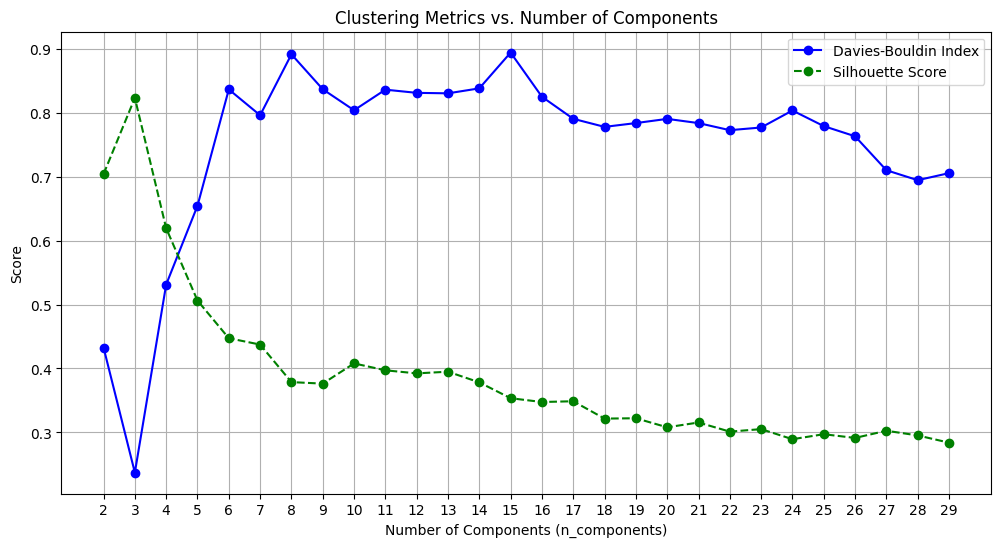

In [17]:
n_components_list = range(2,30) # 튜닝할 클러스터 수 범위
db_scores = []
silhouette_scores = []

for n_components in tqdm(n_components_list):
    # GMM 학습
    gmm = GaussianMixture(n_components, random_state=42)
    gmm.fit(reduced_embeddings)
    clusters = gmm.predict(reduced_embeddings)

    if len(set(clusters)) > 1:
        # DB Score 계산
        db_score = davies_bouldin_score(reduced_embeddings, clusters)
        db_scores.append(db_score)

        # Silhouette Score 계산
        silhouette = silhouette_score(reduced_embeddings, clusters)
        silhouette_scores.append(silhouette)
    else: # 클러스터 댓글 수 1개인 경우 예외 처리
        db_scores.append(np.nan)
        silhouette_scores.append(np.nan)

# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(n_components_list, db_scores, marker="o", linestyle="-", color="b", label="Davies-Bouldin Index")
plt.plot(n_components_list, silhouette_scores, marker="o", linestyle="--", color="g", label="Silhouette Score")
plt.title("Clustering Metrics vs. Number of Components")
plt.xlabel("Number of Components (n_components)")
plt.ylabel("Score")
plt.xticks(n_components_list)
plt.grid()
plt.legend()
plt.show()

## 8. 클러스터링 결과를 활용한 댓글 요약

**깃허브에 업로드 할때는 API KEY를 지우고 업로드 부탁드립니다.**

### 8-1.좋아요 수에 기반해서 각 클러스터마다 댓글 샘플링

In [18]:
#좋아요 수에 기반한 샘플링 함수
def weighted_sample(cluster_df, n_samples):
    if len(cluster_df) <= n_samples: # 샘플링 할 개수보다 클러스터에 속하는 샘플 수가 적으면 클러스터에 속하는 모든 샘플 반환
        return cluster_df
    try:
      weights = cluster_df['num_likes'] / cluster_df['num_likes'].sum()
      sampled = cluster_df.sample(n=n_samples, weights=weights, random_state=42)
    except ValueError as e:
      sampled = cluster_df.sample(n=n_samples, random_state=42)
    return sampled

sampled_comments = []
n_samples_per_cluster = 10  # 샘플링 할 개수

# 샘플링
for cluster in filtered_df['gmm_cluster'].unique():
    cluster_df = filtered_df[filtered_df['gmm_cluster'] == cluster]
    sampled_comments.append(weighted_sample(cluster_df, n_samples_per_cluster))

sampled_comments_df = pd.concat(sampled_comments)

sampled_comments_df

,Unnamed: 0,author,comment,num_likes,kmeans_cluster,hdbscan_cluster,gmm_cluster,agg_cluster,group_cluster
7,138,@임정수-q8z,진짜 이런 고퀄리티 영상을 무료로 볼 수 있다니.....,131,0,1,0,0,6
60,102,@wolfblue41,한국어 지원해주겠다는 소리가 영어판에 자막 다는게 아니라 아예 한국채널을 만들어준다...,14,0,1,0,0,3
37,189,@DelulianDelusio,오늘 이 영상에서 배운것 : &quot;하지만 최악은 아직 말하지도 않았습니다&quot;,28,0,1,0,0,8
21,33,@세송이버섯-j5f,쿠르즈게자트 영상은 항상 마지막 부분에서 못 참고 눈물이 터져요… 모든 메세지가 감...,8,0,1,0,0,2
58,223,@투로-q4z,이 편 정말 재밌었는데 한국어로 들으니까 넘모 좋아~~~~~~~~~~~~~~~~~~...,15,0,1,0,0,3
8,12,@dadvoe,왜 영상 내용에 대해 말하는 사람은 없고 채널 빠는 놈들밖에 없지.....,3,0,1,0,0,1
59,99,@user-bj9iy6db1i,한국어 더빙있는 줄 몰랐네 너무 좋습니다 나머지 영상들도 더빙해줬음 좋겠습니다,3,0,1,0,0,4
57,91,@목깎인형,진짜 보면 볼수록 한국어로 된 앤디 위어 the egg가 제일 기대됩니다,3,0,1,0,0,5
34,186,@김여름-s1g,영상 잘본거 맞음??ㅋㅋㅋㅋㅋ,1,0,1,0,0,7
29,181,@changyoonoh9547,너무 좋습니다. 앞으로도 좋은 영상 부탁드립니다.,1,0,1,0,0,1


### 8-2.ChatGPT를 통해 샘플링한 댓글들로 전체 댓글 경향성 요약

In [19]:
import openai

# ChatGPT에 샘플링한 댓글들을 넘겨줄 문자열 생성 ({클러스터 번호:클러스터에 속하는 댓글들})
clustered_dict = sampled_comments_df.groupby('gmm_cluster')['comment'].apply(list).to_dict()
formatted_string = str(clustered_dict)

print(formatted_string)

{0: ['진짜 이런 고퀄리티 영상을 무료로 볼 수 있다니.....', '한국어 지원해주겠다는 소리가 영어판에 자막 다는게 아니라 아예 한국채널을 만들어준다는 소리였네. 고맙네.', '오늘 이 영상에서 배운것 : &quot;하지만 최악은 아직 말하지도 않았습니다&quot;', '쿠르즈게자트 영상은 항상 마지막 부분에서 못 참고 눈물이 터져요… 모든 메세지가 감동적입니다.', '이 편 정말 재밌었는데 한국어로 들으니까 넘모 좋아~~~~~~~~~~~~~~~~~~~~~ 진짜 넘모 좋아!!!!!!!!!!!!!', '왜 영상 내용에 대해 말하는 사람은 없고 채널 빠는 놈들밖에 없지.....', '한국어 더빙있는 줄 몰랐네 너무 좋습니다 나머지 영상들도 더빙해줬음 좋겠습니다', '진짜 보면 볼수록 한국어로 된 앤디 위어 the egg가 제일 기대됩니다', '영상 잘본거 맞음??ㅋㅋㅋㅋㅋ', '너무 좋습니다. 앞으로도 좋은 영상 부탁드립니다.'], 1: ['2D 모션그래픽인데도 지구에 대재앙이 일어나는 과정 묘사가 살벌하네요 ㄷㄷㄷ', '이번에 때마침 소행성의 궤도를 바꾸는 충돌 실험 DART 프로젝트가 실행되었죠.<br>그 DART의 공식 트위터는 DART가 소행성에 부딛칠때 이렇게 멘트를 날렸다고 합니다.<br>&quot;이건 공룡의 복수다!&quot;', '멍청한 새끼 ㅋㅋ 너 지구가 평평하다 믿지?', '이 사건만 아니였어도 인간은 없는 지구 였을것이다.', '공룡은 수억년간을 생존해도 고차원적인 진화를 이루지 못하였으니<br>외계의 연구가들은<br>거대 파충류에서 작은 포유류로<br>연구 대상을 바꾸기로 결정했다.', '미생물급 제외, 저런 행성급 재앙을 살아남을 수 있는 생물체가 있다는게 신기할 따름.. 뻘소리지만 공룡의 멸종(조류형 공룡들은 생존했지만)과 인류의 출현까지 이 과정이 다소 인위적으로 느껴지기도 함. 외계 문명이 인류 유전자를 심고 실험하기 위한 목적으로 지구를 테라포밍했다던가..', '지구 반대편에 떨어진다고 안심할수가없네 ..', '전체 생명의

In [ ]:
# ChatGPT에게 댓글을 보고 전반적인 경향성 요약 요청
openai.api_key = "" #API KEY

response = openai.chat.completions.create(
    model="gpt-4",
    messages=[
        {"role": "system", "content": "당신은 유튜브 댓글에서 클러스터링을 통해 대표적으로 선별된 몇가지 댓글들을 보고 댓글들의 전체적인 경향성을 요약해서 나타내는 모델입니다."},
        {"role": "user", "content": "다음은 각 클러스터에 속하는 댓글을 가지고온 것입니다. 이것들에 기반해서 전체적인 댓글의 경향성을 요약해주세요."+
         "각 클러스터에 대해서 설명하는 것이 아닌, 문장이 자연스럽게 이어지도록 서술해주세요."
         "존댓말로 서술해주세요."+
         formatted_string}
    ]
)

generated_summary = response.choices[0].message.content

print(generated_summary)

전체적으로 댓글들은 영상의 고품질과 깊이 있는 내용, 그리고 한국어 지원에 감사함을 표현하고 있습니다. 특히, 정교한 모션그래픽을 통해 재현된 공룡의 멸종과 지구에 대재앙이 일어나는 모습이 많은 시청자들에게 깊은 인상을 남겼습니다. 또한, 몇몇 댓글에서는 고퀄리티의 영상들을 무료로 시청할 수 있다는 점에 대한 감사의 의미를 전달하면서, 기대를 표현하고 있습니다. 추가적인 한국어 더빙 영상의 기대감도 드러나는 것을 확인할 수 있었습니다. 게다가 공룡에 대한 연민과 흥미, 그리고 인간의 교만에 대한 경계를 나타내는 댓글들도 존재합니다. 이러한 댓글들을 종합해 보면, 시청자들이 제공된 내용에 대해 매우 긍정적이고 참여적인 자세를 가지고 있음을 알 수 있습니다.


## 9. 시각화


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


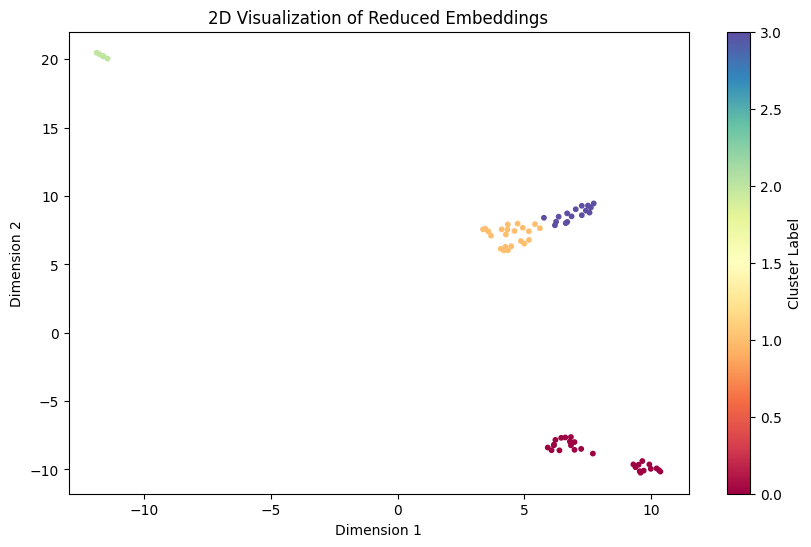

In [21]:
#2차원 시각화
import matplotlib.pyplot as plt

reducer_2d = UMAP(n_neighbors=10, n_components=2, min_dist=0.1, metric='cosine', random_state=42)
embeddings_2d = reducer_2d.fit_transform(reduced_embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],c=filtered_df['gmm_cluster'],  s=10, cmap='Spectral')
plt.colorbar(label="Cluster Label")
plt.title("2D Visualization of Reduced Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [23]:
#3차원 시각화
import plotly.express as px
from umap import UMAP

reducer_3d = UMAP(n_neighbors=10, n_components=3, min_dist=0.1, metric='cosine', random_state=42)
embeddings_3d = reducer_3d.fit_transform(reduced_embeddings)

fig = px.scatter_3d(
    x=embeddings_3d[:, 0],
    y=embeddings_3d[:, 1],
    z=embeddings_3d[:, 2],
    color=filtered_df['gmm_cluster'].astype(str),
    title="3D Visualization of Reduced Embeddings",
    labels={"x": "Dimension 1", "y": "Dimension 2", "z": "Dimension 3"},
    opacity=0.7
)
fig.show()

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

